<a href="https://colab.research.google.com/github/Vinit-source/CSL7382-Medical-image-clustering-assignment.py/blob/main/problem_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem

Implement the **k-means**, **SLIC**, and **Ratio Cut** algorithms for segmenting a given bioimage into multiple segments. Use attached image or any other bioimage to show the segmentation results of your algorithms.

Utility Functions

In [ ]:
def visualize_clusters(image, labels, n_clusters, subp):
    # convert to the shape of a vector of pixel values
    masked_image = np.copy(image)
    masked_image = masked_image.reshape((-1, 3))
    labels = labels.flatten()
    for i in range(n_clusters):
        # color (i.e cluster) to disable
        cluster = i
        masked_image[labels == cluster] = [255-150*i, 255-60*i, 155+3*i]

    # convert back to original shape
    masked_image = masked_image.reshape(image.shape)
    # show the image
    plt.subplot(subp).imshow(masked_image)
    plt.axis('off')

def plot_segmented_image( img, labels, num_clusters, subp):
    labels = labels.reshape( img.shape[:2] )
    plt.subplot(subp).imshow(img)
    plt.axis('off')
    for l in range( num_clusters ):
        try:
            plt.subplot(subp).contour( labels == l, levels=1, colors=[plt.get_cmap('coolwarm')( l / float( num_clusters ))] )
        except ValueError:  #raised if `y` is empty.
            pass


# K-Means

img.shape: (493, 559, 3)
Running KMeans...


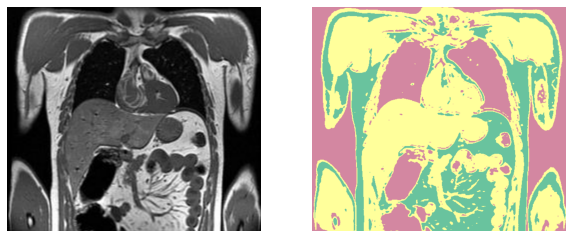

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

class KMeansClustering:
    def runKMeans(self, intensities: np.ndarray, n_clusters: int, n_iterations: int = 20) -> (list, np.array):
        '''
        The KMeans clustering algorithm.
        Returns:
        cluster_labels: list of labels for each point.
        '''
        self.n_clusters = n_clusters
        self.init_centroids(intensities)
        print('Running KMeans...')
        for i in range(n_iterations):
        
            cluster_int, cluster_ind = self.allocate(X, intensities)
            self.update_centroids(cluster_int)

        labels = np.empty((intensities.shape[0]))
        for i in range(n_clusters):
            labels[cluster_ind[i]] = i
        return labels, self.centroids
    
    def init_centroids(self, intensities: np.ndarray):
        '''
        Initialize centroids with random examples (or points) from the dataset.
        '''
        #Number of examples
        l = intensities.shape[0]
        #Initialize centroids array with points from intensities with random indices chosen from 0 to number of examples
        rng = np.random.default_rng()
        self.centroids = intensities[rng.choice(l, size=self.n_clusters, replace=False)]
        self.centroids.astype(np.float32)

    
    def allocate(self, X: np.ndarray, intensities):
        '''
        This function forms new clusters from the centroids updated in the previous iterations.
        '''

        #Step 1: Allocate the closest points to the clusters to fill them with atleast one point.
        # Allocate the remaining points to the closest clusters
        #Calculate the differences in the features between centroids and X using broadcast subtract 
        res = self.centroids - intensities[:, np.newaxis]

        #Find Manhattan distances of each point with all centroids 
        dist = np.absolute(res)
        
        #Find the closest centroid from each point. 
        # Find unique indices of the closest points. Using res again for optimization
        #not unique indices
        res =  np.where(dist == dist.min(axis=1)[:, np.newaxis])  
        
        #res[0] is used as indices for row-wise indices in res[1]
        min_indices = res[1][np.unique(res[0])] 
    
        indices = [[] for i in range(self.n_clusters)]
        for i, c in enumerate(min_indices):
            if not c == -1:
                # cluster_array[c] = np.append(cluster_array[c], [X[i]], axis=0)    #add the point to the corresponding cluster
                indices[c].append(i)
    
        return [intensities[indices[i]] for i in range(self.n_clusters)], indices
    
    def update_centroids(self, cluster_int):
        '''
        This function updates the centroids based on the updated clusters.
        '''
        #Make a rough copy
        centroids = self.centroids
    
        #Find mean for every cluster
        for i in range(self.n_clusters):
            if len(cluster_int[i]) > 0:
                centroids[i] = np.mean(cluster_int[i])
        #Update fair copy 
        self.centroids = centroids

if __name__ == '__main__':
    img = Image.open('f1.png')
    plt.figure(figsize=(10,20))
    plt.subplot(121).imshow(img)
    plt.axis('off')
    img = np.array(img)
    print(f'img.shape: {img.shape}')
    X = []
    intensities = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            X.append([i, j])
            intensities.append(np.average(img[i][j]))
    X = np.array(X)
    intensities = np.array(intensities)

    k = 3
    KMC = KMeansClustering()
    labels, centroids = KMC.runKMeans(intensities, k, 10)
    visualize_clusters(img, labels, k, 122)
    
    plt.show()

# SLIC

img.shape: (493, 559, 3)


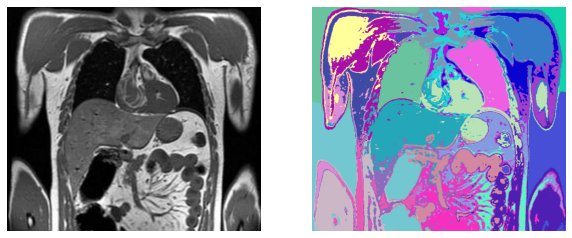

In [ ]:
import numpy as np
from numpy import linalg as la
from PIL import Image
import sys
import matplotlib.pyplot as plt
from time import perf_counter

class SLIC:
    def runSlic(self, X: np.ndarray, intensities: np.ndarray, n_clusters: int, n_iterations: int, lmbda: float) -> list:
        '''
        The SLIC clustering algorithm.
        Returns:
        cluster_labels: list of labels for each point.
        '''
        self.n_clusters = n_clusters
        self.init_centroids(X, intensities)

        for i in range(n_iterations):
            cluster_int, cluster_loc, indices = self.allocate(X, intensities, lmbda)
            self.update_centroids(cluster_int, cluster_loc)

        labels = np.empty((X.shape[0]))
        for i in range(n_clusters):
            labels[indices[i]] = i
        return labels
    
    def init_centroids(self, X, intensities: np.ndarray):
        '''
        Initialize centroids with random examples (or points) from the dataset.
        '''
        #Number of examples
        l = intensities.shape[0]
        #Initialize centroids array with points from intensities with random indices chosen from 0 to number of examples
        rng = np.random.default_rng()
        indices = rng.choice(l, size=self.n_clusters, replace=False)
        self.centroids_c = X[indices]
        self.centroids_i = intensities[indices]
        self.centroids_i.astype(np.float32)

    
    def allocate(self, X: np.ndarray, intensities, lmbda):
        '''
        This function forms new clusters from the centroids updated in the previous iterations.
        '''
        # Allocate the points to the closest clusters
        #Calculate the differences in the features between centroids and X using broadcast subtract 
        dist = np.absolute(self.centroids_i - intensities[:, np.newaxis]) + lmbda * la.norm(self.centroids_c - X[:, np.newaxis], axis=2)
        
        #Find the closest centroid from each point. 
        # Find unique indices of the closest points. Using res again for optimization
        #not unique indices
        res =  np.where(dist == dist.min(axis=1)[:, np.newaxis])  
        #res[0] is used as indices for row-wise indices in res[1]
        min_indices = res[1][np.unique(res[0])] 

        indices = [[] for i in range(self.n_clusters)]
        for i, c in enumerate(min_indices):
            if not c == -1:
                indices[c].append(i)

        return [intensities[indices[i]] for i in range(self.n_clusters)], \
            [X[indices[i]] for i in range(self.n_clusters)], indices
    
    def update_centroids(self, cluster_int, cluster_loc):
        '''
        This function updates the centroids based on the updated clusters.
        '''
        #Make a rough copy
        centroids_c = self.centroids_c
        centroids_i = self.centroids_i

        #Find mean for every cluster
        for i in range(self.n_clusters):
            if len(cluster_int[i]) > 0:
                centroids_i[i] = np.mean(cluster_int[i])
                centroids_c[i] = np.mean(cluster_loc[i], axis=0)
        #Update fair copy 
        self.centroids_i = centroids_i
        self.centroids_c = centroids_c

if __name__ == '__main__':
    img = Image.open('f1.png')
    plt.figure(figsize=(10, 20))
    plt.subplot('121').imshow(img)
    plt.axis('off')
    img = np.array(img)
    print(f'img.shape: {img.shape}')
    X = []
    intensities = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            X.append([i, j])
            intensities.append(np.average(img[i][j]))
    X = np.array(X)
    intensities = np.array(intensities)
    k = 25
    slic = SLIC()
    labels = slic.runSlic(X, intensities, k, 20, 0.25)
    visualize_clusters(img, labels, k, 122)
    # plot_segmented_image(img, labels, k)
    plt.show()


# Ratio Cut

Constructing Laplacian matrix...
Performing Eigen Value Decomposition of L...
kmeans2 labels: [1 1 1 ... 1 1 1]


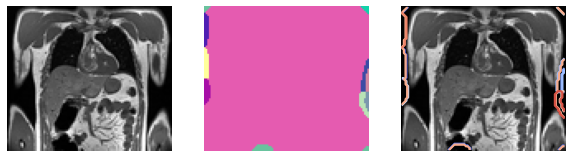

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image
from numpy import linalg as la
import scipy.cluster.vq as vq
import matplotlib.pyplot as plt
import warnings
import math

warnings.simplefilter('ignore')

class Spectralclustering:
    def run(self, img, k, LOAD=True, lmbda=0.25, sigma=1):
        if not LOAD:
            print('Constructing Laplacian matrix...')
            L = self.construct_L(img, lmbda, sigma)
    
            print('Performing Eigen Value Decomposition of L...')
            l, V = la.eigh( L )
    
            with open('array.npy', 'wb') as fp:
                np.save(fp, V, allow_pickle=True)
        else:
            V = np.load('array.npy')

        # First K columns of V need to be clustered
        H = V[:,0:k]
        if( k==2 ):
        # In this case clustering on the Fiedler vector which gives very close approximation
            f = H[:,1]
            labels = np.ravel( np.sign( f ) )
    
            k=2
        else:
            # Run K-Means on eigenvector matrix 
            centroids, labels = vq.kmeans2( H[:,:k], k )
            print(f'kmeans2 labels: {labels}')
    

        return labels

    def construct_L(self, img: np.ndarray, lmbda: int, sigma: int):
        try:
            h, w = img.shape[:2]
        except AttributeError:
            raise('img should be numpy array.')
        L = np.zeros((h*w, h*w))
        D = np.zeros((h*w,))
        for i in range(h):
            for j in range(w):
                # i - 1, j - 1
                if i - 1 >= 0 and j - 1 >= 0:
                    L[(i - 1) * w + (j - 1)][i * w + j] = L[i * w + j][(i - 1) * w + (j - 1)] = -self.sim(img[i][j], i, j, img[i-1][j-1], i-1, j-1, lmbda, sigma)
                    D[i * w + j] += 1
                    D[(i - 1) * w + (j - 1)] += 1
                # i - 1, j
                if i - 1 >= 0:
                    L[(i - 1) * w + j][i * w + j] = L[i * w + j][(i - 1) * w + j] = -self.sim(img[i][j], i, j, img[i-1][j], i-1, j, lmbda, sigma)
                    D[(i - 1) * w + j] += 1
                    D[i * w + j] += 1
                # i - 1, j + 1
                if i - 1 >= 0 and j + 1 < w:
                    L[(i - 1) * w + (j + 1)][i * w + j] = L[i * w + j][(i - 1) * w + (j + 1)] = -self.sim(img[i][j], i, j, img[i-1][j+1], i-1, j+1, lmbda, sigma)
                    D[(i - 1) * w + (j + 1)] += 1
                    D[i * w + j] += 1
                # i, j - 1
                if j - 1 >= 0:
                    
                    L[i * w + (j - 1)][i * w + j] = L[i * w + j][i * w + (j - 1)] = -self.sim(img[i][j], i, j, img[i][j-1], i, j-1, lmbda, sigma)
                    D[i * w + (j - 1)] += 1
                    D[i * w + j] += 1
        
        for i in range(h):
            for j in range(w):
                L[i * w + j][i * w + j] = D[i * w + j]
        return L

    def sim(self, x1, i1, j1, x2, i2, j2, lmbda = 0.25, sigma = 1):
        dist = np.linalg.norm([x1 - x2]) + lmbda * np.linalg.norm([i1 - i2, j1 - j2])

        return math.exp(-(dist/sigma**2))

if __name__ == '__main__':
    img = Image.open('/content/f1.png')
    k = 10
    LOAD = False
    # '''
    # --------------------------------------
    # CODE TO RESIZE ARRAY TO LOWER SIZE
    # ORIGINAL IMAGE WAS EXCEEDING MEMORY
    # --------------------------------------
    basewidth = 100
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    # Convert image to grayscale
    gray = img.convert('L')
    
    # Normalise image intensities to [0,1] values
    gray = np.asarray(gray).astype(float)/255.0

    # gray = np.array([[0, 1, 0], [1,0,1], [0,1,0]], dtype=float)
    s = Spectralclustering()
    labels = s.run(gray, k, LOAD=LOAD, lmbda=0.25, sigma=1)
    # labels = labels.reshape( gray.shape )
    # plot_segmented_image( img, labels, k, None, 'Spectral Clustering' )
    img = np.array(img)
    plt.figure(figsize=(10, 30))
    plt.subplot(131).imshow(img)
    plt.axis('off')
    visualize_clusters(img, labels, k,132)
    plot_segmented_image(img, labels, k, 133)
    plt.show()

### Library Function

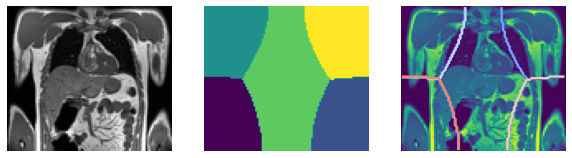

In [ ]:
# import kmeans
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image
from numpy import linalg as la
import scipy.cluster.vq as vq
import matplotlib.pyplot as plt
import warnings
import math
import logging
from sklearn.cluster import SpectralClustering
warnings.simplefilter('ignore')

def sim(x1, i1, j1, x2, i2, j2, lmbda = 0.25, sigma = 1):
    dist = np.linalg.norm([x1 - x2]) + lmbda * np.linalg.norm([i1 - i2, j1 - j2])
    return math.exp(-(dist/sigma**2))

def construct_W(img: np.ndarray, lmbda: float, sigma: float):
    try:
        h, w = img.shape[:2]
    except AttributeError:
        raise('img should be numpy array.')
    L = np.zeros((h*w, h*w))
    D = np.zeros((h*w,))
    for i in range(h):
        for j in range(w):
            # i - 1, j - 1
            if i - 1 >= 0 and j - 1 >= 0:
                L[(i - 1) * w + (j - 1)][i * w + j] = L[i * w + j][(i - 1) * w + (j - 1)] = sim(img[i][j], i, j, img[i-1][j-1], i-1, j-1, lmbda, sigma)
            # i - 1, j
            if i - 1 >= 0:
                L[(i - 1) * w + j][i * w + j] = L[i * w + j][(i - 1) * w + j] = sim(img[i][j], i, j, img[i-1][j], i-1, j, lmbda, sigma)
            # i - 1, j + 1
            if i - 1 >= 0 and j + 1 < w:
                L[(i - 1) * w + (j + 1)][i * w + j] = L[i * w + j][(i - 1) * w + (j + 1)] = sim(img[i][j], i, j, img[i-1][j+1], i-1, j+1, lmbda, sigma)
            # i, j - 1
            if j - 1 >= 0:
                L[i * w + (j - 1)][i * w + j] = L[i * w + j][i * w + (j - 1)] = sim(img[i][j], i, j, img[i][j-1], i, j-1, lmbda, sigma)
    return L



def visualize_clusters_r(image, labels, n_clusters, subp):
    # convert to the shape of a vector of pixel values
    masked_image = np.copy(image)
    labels = labels.flatten()
    masked_image = masked_image.reshape(-1)
    for i in range(n_clusters):
        # color (i.e cluster) to disable
        cluster = i
        masked_image[labels == cluster] =  255-20*i

    # convert back to original shape
    masked_image = masked_image.reshape(image.shape)
    # show the image
    plt.subplot(subp).imshow(masked_image)
    plt.axis('off')

if __name__ == '__main__':
    img = Image.open('/content/f1.png')
    k = 5
    # --------------------------------------
    # CODE TO RESIZE ARRAY TO LOWER SIZE
    # ORIGINAL IMAGE WAS EXCEEDING MEMORY
    # --------------------------------------
    basewidth = 100
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    plt.figure(figsize=(10, 30))
    plt.subplot(131).imshow(img)
    plt.axis('off')
    # Convert image to grayscale
    img = img.convert('L')

    # Normalise image intensities to [0,1] values
    img = np.asarray(img).astype(float)/255.0

    # img = np.array([[0, 1, 0], [1,0,1], [0,1,0]], dtype=float)
    logging.debug(f'img:{img}\nimg.shape: {img.shape}')

    W = construct_W(img, 0, 1)
    sc = SpectralClustering(k, affinity='precomputed', n_init=10,
                        assign_labels='kmeans')
    labels = sc.fit_predict(W) 
    visualize_clusters_r(img, labels, k, 132)
    plot_segmented_image( img, labels, k, 133)
    plt.show()